# EE353 ASSIGNMENT 2
#### PRIYANSH SINGH
#### 22B1856
#### LINK TO THE EXPLANATORY VIDEO: 

NOTE: For uniformity, multi-dimensional variables are named using uppercase and scalars using lowercase 

In [1]:
#data handling and basic math libraries
import pandas as pd
import numpy as np

#time library for complexity analysis
import time

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Task 1 - Data matrix generation

## Function taking a generator matrix and giving a data matrix with desired correlations as output
#### Taking all the columns of the intermediate random matrix as IID sampled 

In [2]:
def gen_data_matrix(n, S):#function declaration - this function can accomodate even non numpy arrays, they will be converted inside the function
    m = np.array(S).shape[0] #extracting the number of rows in S as m
    #[1]
    RANDOM_ARR = np.zeros((n,m)) #initialising the random array as the n x m zero matrix 
    for i in range(n): #looping through the rows of RANDOM_ARR
        for j in range(m): #looping through the columns of RANDOM_ARR 
            RANDOM_ARR[i][j] = np.random.normal(0, 1) #setting each element of RANDOM_ARR as a random sample from a standard normal distribution
    
    #multiplying RANDOM_ARR with the generator matrix
    X = np.dot(RANDOM_ARR, np.array(S)) #np.dot takes the dot product
    return X #function return

### Checking the above function for an identity generator matrix 

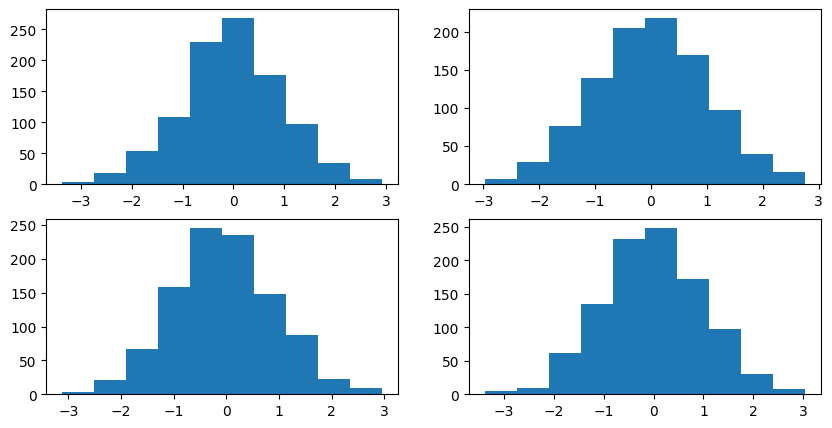

In [3]:
n = 1000 #setting the number of data points
S = np.identity(n) #setting the generator matrix as identity using numpy
X = gen_data_matrix(n, S) #calling the function over these inputs

#creating histograms to display the distribution for the first 4 columns - expected to be gaussian
plt.figure(figsize=(10,5)) #setting output window size
for i in range(4): #looping for multiple subplots 
    plt.subplot(2, 2, i + 1) #subplot used to avpid all the histograms getting displayed on the same figure
    plt.hist(X[:,i]) #histogram of an array using plt.hist

# Task 2 - Function to generate the target vector

In [4]:
def get_target(X, W, noise_var):#predicted target vector for the given weights
    d = np.array(X).shape[1] #number of columns in X
    #dimension mismatch check
    if(len(W) != d + 1):
       #[2]
       raise RuntimeError(f"Provided weight vector is of dimension {len(W)}, expected {d+1}") #raises runtime error for dimesion mismatch
    #If dimensions match
    TARGET = np.dot(np.array(X), W[0:d]) + W[d] + np.random.normal(0, noise_var) #target calculation using dot product and adding the bias and noise
    return TARGET #function return

### Testing the dimension mismatch condition
#### Expected output would be a Runtime Error: "Provided weight vector is of dimension 4, expected 1001"

In [5]:
get_target(X, [1,1,1,1], 0)#calling the function over X, of dimension 1000 x 1000 generated above and W of length 4

RuntimeError: Provided weight vector is of dimension 4, expected 1001

# Task 3 - Analysing the time complexity of the algorithm used in np.linalg.pinv()

In [6]:
time_taken_arr = [] #this list will store the time taken along with the matrix size
#the following loop will create random i x 10 matrices with each entry uniformly sampled from [0,1] and then will compute pinv
for i in range(10000):
    RANDOM_MATRIX_0_1 = np.random.rand(i, 10) #creates a random i x 10 matrix with each entry sampled from [0,1] 
    time_init = time.time() #this function tells time in seconds passed since January 1, 1970
    PINV_RANDOM_MATRIX_0_1 = np.linalg.pinv(RANDOM_MATRIX_0_1) #Calling the pinv function which takes some finite time to run
    time_taken_arr.append([i, time.time() - time_init]) #appending a row to the array containing i and the time elapsed

time_taken_arr = np.array(time_taken_arr) #Converting the array to a numpy array for ease of operations 
    

### Plotting the variation on a log scale plot

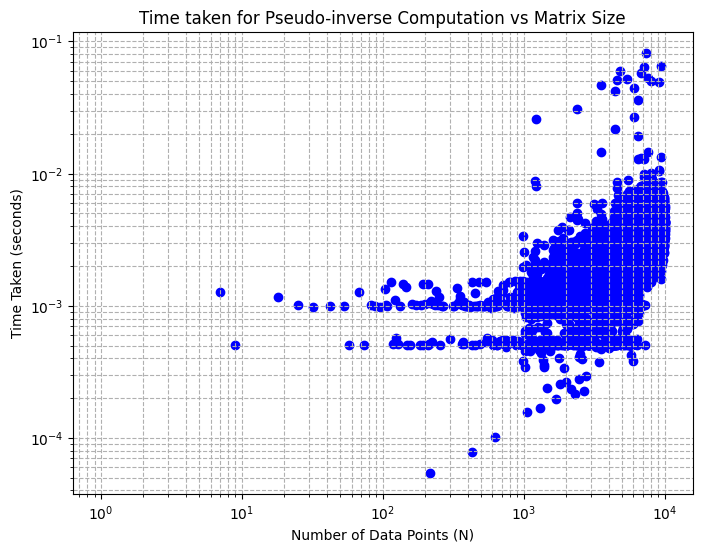

In [7]:
# Plot the results on a log-log scale
plt.figure(figsize=(8, 6)) #function return
plt.scatter(time_taken_arr[:,0], time_taken_arr[:, 1], marker='o', color='b') #scatter plot of the time taken

#[3]
plt.xscale('log') # Setting log scale for x axis
plt.yscale('log') # Setting log scale for y axis

plt.xlabel('Number of Data Points (N)') #x axis label
plt.ylabel('Time Taken (seconds)') #y axis label
plt.title('Time taken for Pseudo-inverse Computation vs Matrix Size') #plot title

plt.grid(True, which="both", ls="--") #setting the plot for the grid
plt.show() #show the plot


#### OBSERVATION: The time taken stays almost ocntant up until array size 1000, when the complexity starts to increase, but not monotonically, it actually oscillates and slowly drifts up. Analysing the possible reasons:  
1. Random elements : I tested the time complexity with arrays containing just ones, and such a plot was still observed, so the random assignment is not the reason.
2. Internal algorithm : The np.linalg.pinv method invokes SVD on the input matrix which has a complexity of N^2 for our case, this might be the reason, along with other computation mechanisms for the sudden jump in the time elapsed at high values of N 

#### To demonstrate the overall drift/trend in the values of the time complexity over the varying values of N after N = 1000, a window averaging over the values of the time taken can be done after N = 1000  

In [8]:
window_average = [] #this list would store the time taken values averaged over a window of 10 entries
window_size = 10 #size of the window, ie, the number of elements averaged
for i in window_size*(np.arange(int(1000/window_size), int(10000/window_size))): #looping through the time taken array to take the average     
    window_average.append([np.mean(time_taken_arr[:,0][i:i + window_size]),np.mean(time_taken_arr[:,1][i:i + window_size])]) #storing the average N and the average time taken in the window average list
window_average = np.array(window_average)#converting the list to a numpy array for ease of calculation 

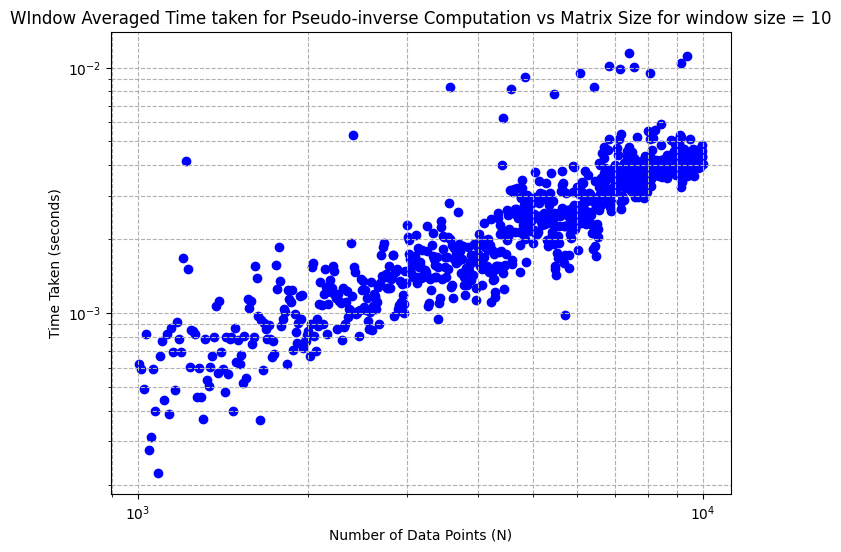

In [9]:
# Plot the results on a log-log scale
plt.figure(figsize=(8, 6))
plt.scatter(window_average[:,0], window_average[:, 1], marker='o', color='b')

#[3]
plt.xscale('log') # Setting log scale for x axis
plt.yscale('log') # Setting log scale for y axis

plt.xlabel('Number of Data Points (N)') #x axis label
plt.ylabel('Time Taken (seconds)') #y axis label
plt.title(f"WIndow Averaged Time taken for Pseudo-inverse Computation vs Matrix Size for window size = {window_size}") #plot title

plt.grid(True, which="both", ls="--") #setting the plot for the grid
plt.show() #show the plot

# Task 4 - Normalized Root Mean Squared Error

#### RMSE can be normalized by multiple different parameters of the target matrix, here we use the standard deviation of the target variable  
#### NRMSE = $\frac{RMSE}{standard \ deviation \ of \ target}$   

In [10]:
def nrmse(T, Y): #function declaration
    #For ease of programming, converting T and Y to numpy arrays using np.array(T) and np.array(Y)  
    sse = np.sum((np.array(T) - np.array(Y))**2) #np.sum computes the sum of all the entries in an array 
    rmse = np.sqrt(sse/len(T)) #RMSE form SSE
    target_stdev = np.std(T) #standard deviation of Target array
    nrmse = rmse/target_stdev #normalization
    return nrmse #function return

# Task 5 - Gradient of MSE 

#### Appending a column [1,1,1,...] to X, we'll get the expression for MSE as the following
#### MSE = $\sum_{i=1}^{n} \frac{(t_i - X_iW - noise)^2}{n}$
#### Here, W includes the bias
#### $ \nabla_W $ MSE = $\sum_{i=1}^{n} \frac{2(X_iW + noise - t_i)(X_i)}{n}$  
#### Inputs to the function: Target, Prediction and Data matrix    

In [11]:
def grad_mse(Y, T, X): #Y : predictions for all the datapoints T : Targets for all the datapoints 
    GRAD_MSE =  np.zeros((np.array(X).shape[1]) + 1) #this array of length d + 1 will be the gradient vector

    for i in range(len(T)):#looping through all the datapoints for summation 
        X_i = np.array(X[i]) #ith row of X - that is the ith datapoint
        X_i = np.append(X_i, 1) #appending 1 to the ith row to accomodate for bias in W 
        #Assuming W is of length d+1, including the bias
        GRAD_MSE = GRAD_MSE + 2*(Y[i] - T[i])*(X_i) #calculation

    GRAD_MSE = GRAD_MSE/len(T) #dividing by n for mean
    return GRAD_MSE #function return

# Task 6, 7 - Gradient of L2 and L1 norms
## L2
#### L2 penalty = $\frac{W^TW}{2}$
#### $ \nabla_W $ L2 penalty = W 
## L1
#### L1 penalty = $\sum_{i=0}^{d-1} |W[i]|$  
#### $ \nabla_W $ L1 penalty = [sgn(W[0]), sgn(W[1]), ..., sgn(W[d-1])], where sgn(x) = -1 if x < 0 and 1 otherwise
### L1 and L2 are applied only on the weights and not the bias, so W here includes only d entries, not d+1

In [12]:
def grad_l2(W): #function declaration
    return W[0:len(W) - 1] #returns the first d entries of W

def grad_l1(W): #function declaration
    GRAD_L1 = [] #this list will store the gradient
    for i in range(len(W) - 1): #looping only through the first d entries
        GRAD_L1.append(1 if W[i] >= 0 else -1) #appends the signum of the weight to the list
    GRAD_L1 = np.array(GRAD_L1) #converting GRAD_L1 to a numpy array for ease of programming
    return GRAD_L1 #function return

# Task 8 - Gradient descent

In [13]:
NRMSE_values = [] #this will hold the NRMSE values as the gradient descent proceeds, optionally given at the output

def grad_descent(X, T, noise_var, l2_coeff, l1_coeff, learning_rate): #Returns the best weights and (optionally) the NRMSE values
    W_OLD = np.random.rand(np.array(X).shape[1] + 1) #random array of dimension d + 1
    L2_PENALTY = np.append(l2_coeff*grad_l2(W_OLD), 0) #appending 0 to the L2 GRADIENT array to make it of dimension d+1 for adding to the MSE gradient
    L1_PENALTY = np.append(l1_coeff*grad_l1(W_OLD), 0) #appending 0 to the L1 GRADIENT array to make it of dimension d+1 for adding to the MSE gradient
    GRADIENT_W_OLD = grad_mse(get_target(X, W_OLD, noise_var), T, X) +  L2_PENALTY + L1_PENALTY #total gradient
    W_NEW = W_OLD - learning_rate*(GRADIENT_W_OLD) #Weight update equation
    NRMSE_values.append(nrmse(T, get_target(X, W_NEW, noise_var))) #appending the nrmse value to the arrray
    i = 0 #variable to hold the number of iterations
    #while(((nrmse(T, get_target(X, W_OLD, noise_var)) - nrmse(T, get_target(X, W_NEW, noise_var)) > 0.001) or (nrmse(T, get_target(X, W_NEW, noise_var)) > 1)) and i < 5000):#running the loop with the termination condition on the NRMSE 
    while((nrmse(T, get_target(X, W_NEW, noise_var)) > 3) and i < 500):#running the loop with the termination condition on the NRMSE 
          W_OLD = W_NEW #updating W_OLD for further iteration
          L2_PENALTY = np.append(l2_coeff*grad_l2(W_OLD), 0) #appending 0 to the L2 GRADIENT array to make it of dimension d+1 for adding to the MSE gradient
          L1_PENALTY = np.append(l1_coeff*grad_l1(W_OLD), 0) #appending 0 to the L1 GRADIENT array to make it of dimension d+1 for adding to the MSE gradient
          GRADIENT_W_OLD = grad_mse(get_target(X, W_OLD, noise_var), T, X) +  L2_PENALTY + L1_PENALTY #total gradient
          W_NEW = W_OLD - learning_rate*(GRADIENT_W_OLD) #Weight update equation
          NRMSE_values.append(nrmse(T, get_target(X, W_NEW, noise_var))) #appending the nrmse value to the arrray
          i += 1 #incrementing i after each iterations
    
    return W_NEW #function return

#### Testing the gradient descent function over a Kaggle dataset to ensure convergence

In [14]:
df = pd.read_csv("Customer Purchasing Behaviors.csv") #reading the dataframe
data_x = df[['age', 'annual_income', 'loyalty_score']] #independent variable
data_x_norm = data_x.div(data_x.max()) #normalizing each column of the X matrix by dividing it with the maximum value in the column 
data_y = df['purchase_amount'] #dependent variable
data_y_norm = data_y.div(data_y.max()) #normalizing each column of the Y array by dividing it with the maximum value in the column 

In [15]:
W_OPTIMAL = grad_descent(np.array(data_x_norm), np.array(data_y_norm), 0, 0.5, 0.5, 0.01) #running the gradient descent on the normalized data

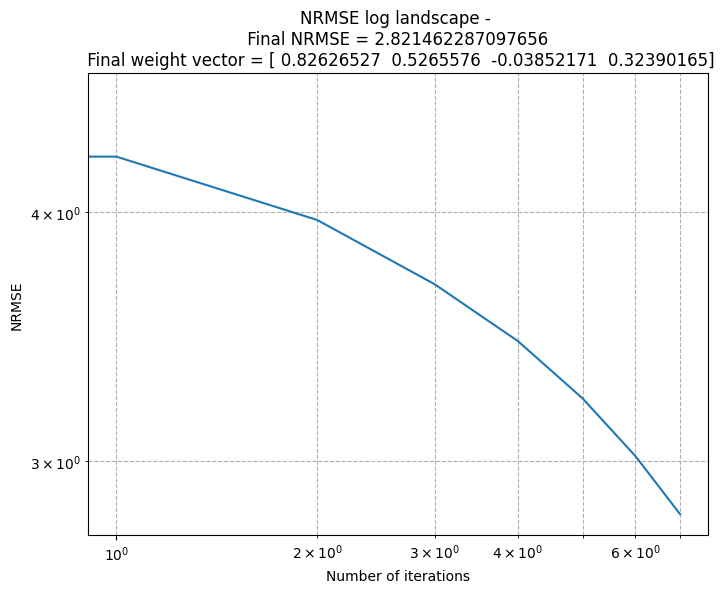

In [16]:
# Plot the results in log-log scale
plt.figure(figsize=(8, 6)) #output window size
plt.plot(np.arange(len(NRMSE_values)), NRMSE_values) #plotting the data

#[3]
plt.xscale('log') # Setting log scale for x axis
plt.yscale('log') # Setting log scale for y axis

# Add labels and title
plt.xlabel('Number of iterations') #x axis label
plt.ylabel('NRMSE') #y axis label
plt.title(f"NRMSE log landscape - \n Final NRMSE = {NRMSE_values[len(NRMSE_values) - 1]} \n Final weight vector = {W_OPTIMAL}") #plot title

plt.grid(True, which="both", ls="--") #setting the plot for the grid
plt.show() #show the plot

# Task 9 - Impact of noise variance on NRMSE

### Method:  
- Randomly generate five values of noise variance between 0 and 3
- Generate X with an identity generator and T randomly for each sigma: Xi,Ti for i in {1, 2, 3, 4, 5}
- Randomly split these matrices into test and validation: X_t_i, X_v_i, T_t_i, T_v_i
- Train using gradient descent on the train subset and test on the validation subset 

### Set of noise variance values

In [17]:
noise_var_arr = 3*np.random.rand(5) #Generating values of variance randomly from the range [0,3] 
noise_var_arr = np.sort(noise_var_arr) #sorting it for plotting ease

### Data generation - taking X to be n x d

In [18]:
n = 100 #number of datapoints
d = 3 #dimension of each datapoint

Data_tensor = np.zeros((n, d, len(noise_var_arr))) #This tensor will store the five different data matrices
for i in range(len(noise_var_arr)): #looping for the different data matrices associated to each noise variance
    Data_tensor[:,:,i] = gen_data_matrix(n, np.identity(d)) #generating the data matrix for each noise variance with the identity generator

Target_array = np.zeros((n, len(noise_var_arr))) #This array will store the five different target arrays
for i in range(len(noise_var_arr)): #looping for the different target arrays associated to each noise variance
    Target_array[:, i] = np.random.rand(n) #randomly assigning values to the target array

### Data split - 4:1 ratio split
- Size of Test data = $\frac{4n}{5}$
- Size of Validation data = $\frac{n}{5}$
- The dataset was generated randomly, so the splitting can be done by taking the top $\frac{4n}{5}$ entries as train and the rest as validation

In [19]:
Train_data_tensor = Data_tensor[0:int(4*n/5), :, :] #slicing the Data tensor for the first 4n/5 entries for training
Train_target_array = Target_array[0:int(4*n/5), :] #slicing the Target array for the first 4n/5 entries for training

Test_data_tensor = Data_tensor[int(4*n/5):int(n), :, :]  #slicing the Data tensor for the last n/5 entries for validation
Test_target_array = Target_array[int(4*n/5):int(n), :]  #slicing the Target array for the last n/5 entries for validation

### Gradient descent on the train sets

In [20]:
Weight_array = [] #holds the weights for all the iterations 
NRMSE_array = [] #holds the NRMSE values for all the iterations
for i in range(len(noise_var_arr)): #looping for all the different noise variance values
    Weight_array.append(grad_descent(Train_data_tensor[:,:,i], Train_target_array[:,i], noise_var_arr[i], 0, 0.5, 0.001)) #updating the weight array
    NRMSE_array.append([noise_var_arr[i], nrmse(Test_target_array[:,i], get_target(Test_data_tensor[:,:,i], Weight_array[i], noise_var_arr[i]))]) #updating the NRMSE array with NRMSE on the validation subset
NRMSE_array = np.array(NRMSE_array) #converting to numpy array for ease of use

## Conducting the above task five times iteratively followed by averaging

In [21]:
average_NRMSE_array_task_9 = np.zeros((5, 2)) #this will hold the average of the NRMSE values throughout the iterations

noise_var_arr = 3*np.random.rand(5) #Generating values of variance randomly from the range [0,3] 
noise_var_arr = np.sort(noise_var_arr) #sorting it for plotting ease

for i in range(5):
    n = 100 #number of datapoints
    d = 3 #dimension of each datapoint

    Data_tensor = np.zeros((n, d, len(noise_var_arr))) #This tensor will store the five different data matrices
    for i in range(len(noise_var_arr)): #looping for the different data matrices associated to each noise variance
        Data_tensor[:,:,i] = gen_data_matrix(n, np.identity(d)) #generating the data matrix for each noise variance with the identity generator

    Target_array = np.zeros((n, len(noise_var_arr))) #This array will store the five different target arrays
    for i in range(len(noise_var_arr)): #looping for the different target arrays associated to each noise variance
        Target_array[:, i] = np.random.normal(0, 1, n) #randomly assigning gaussian sampled values to the target array

    Train_data_tensor = Data_tensor[0:int(4*n/5), :, :] #slicing the Data tensor for the first 4n/5 entries for training
    Train_target_array = Target_array[0:int(4*n/5), :] #slicing the Target array for the first 4n/5 entries for training

    Test_data_tensor = Data_tensor[int(4*n/5):int(n), :, :]  #slicing the Data tensor for the last n/5 entries for validation
    Test_target_array = Target_array[int(4*n/5):int(n), :]  #slicing the Target array for the last n/5 entries for validation

    Weight_array = [] #holds the weights for all the iterations 
    NRMSE_array = [] #holds the NRMSE values for all the iterations 
    for i in range(len(noise_var_arr)): #looping for all the different noise variance values
        Weight_array.append(grad_descent(Train_data_tensor[:,:,i], Train_target_array[:,i], noise_var_arr[i], 0, 0.5, 0.001)) #updating the weight array
        NRMSE_array.append([noise_var_arr[i], nrmse(Test_target_array[:,i], get_target(Test_data_tensor[:,:,i], Weight_array[i], noise_var_arr[i]))]) #updating the NRMSE array
    NRMSE_array = np.array(NRMSE_array) #converting to numpy array for ease of use

    average_NRMSE_array_task_9 += NRMSE_array #adding the NRMSE array to be used for averaging

average_NRMSE_array_task_9 = average_NRMSE_array_task_9/5 #dividing by 5 for averaging over all the iterations

### Plotting the NRMSE against the noise variance values

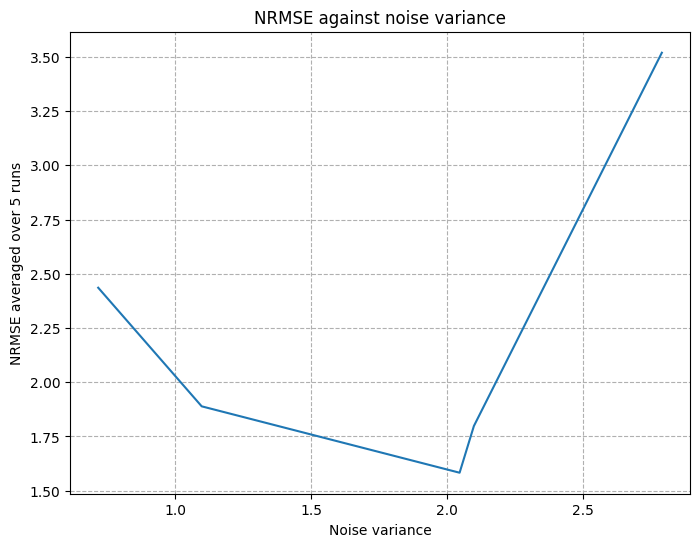

In [22]:
# Plot the results on a log-log scale
plt.figure(figsize=(8, 6)) #output window size 
plt.plot(average_NRMSE_array_task_9[:,0], average_NRMSE_array_task_9[:,1]) #plot of the average values

# Add labels and title
plt.xlabel('Noise variance') #x axis label
plt.ylabel('NRMSE averaged over 5 runs') #y axis label
plt.title("NRMSE against noise variance") #plot title

plt.grid(True, which="both", ls="--") #setting the plot for the grid
plt.show() #show the plot

# Task 10 - Impact of N and $\lambda_2$ on the NRMSE for Linear regression

- The experiment is run on 5 Iterations, G and $\sigma$ being constant throughout the iterations. Taking G to be a 5x5 identity matrix, i.e., d = 5
- Keeping $\lambda_1$ = 0

### Generating N and $\lambda_2$ array 

In [23]:
l2_coeff_array = np.sort(np.random.rand(5)) #generates a sorted random array of length 5 with values uniformly sampled from [0,1)
#[4]
N_array = np.sort(np.random.randint(low=500, high=5000, size=5)) #generates a random length 5 array with integer values uniformly sampled from {500, 501,..., 5000} 
#Sorting helps in organized plotting 

- Generating the data matrices and splitting them

In [24]:
noise_var_task_10 = 0.5 #choosing noise variance
d = 5 #dimension of each datapoint

#[5]
Data_array_task_10 = np.empty(len(N_array), dtype=object) #This array of objects will store the 5 different data matrices
Target_array_task_10 = np.empty(len(N_array), dtype=object) #This array of objects will store the 5 different target arrays

Train_data_array_task_10 = np.empty(len(N_array), dtype=object) #This array of objects will store the 5 different train data matrices
Test_data_array_task_10 = np.empty(len(N_array), dtype=object)  #This array of objects will store the 5 different test data matrices

Train_target_array_task_10 = np.empty(len(N_array), dtype=object) #This array of objects will store the 5 different train target arrays
Test_target_array_task_10 = np.empty(len(N_array), dtype=object)  #This array of objects will store the 5 different test target arrays

for j in range(len(N_array)): #looping through the array of N values
    n = N_array[j] #reading the jth entry of the array of N values
    Data_array_task_10[j] = gen_data_matrix(n, np.identity(d)) #generating the data matrix for each N with the identity generator
    Target_array_task_10[j] = np.random.normal(0, 1, n) #randomly assigning gaussian sampled values to the target array
    
    Train_data_array_task_10[j] = Data_array_task_10[j][0:int(4*n/5)] #slicing the Data tensor for the first 4n/5 entries for training
    Test_data_array_task_10[j] = Data_array_task_10[j][int(4*n/5):int(n)] #slicing the Data tensor for the last n/5 entries for validation
    
    Train_target_array_task_10[j] = Target_array_task_10[j][0:int(4*n/5)] #slicing the Target array for the first 4n/5 entries for training
    Test_target_array_task_10[j]  = Target_array_task_10[j][int(4*n/5):int(n)]  #slicing the Target array for the last n/5 entries for validation

- Conducting the experiment looping 5 times

In [25]:
average_NRMSE_array_task_10 = np.zeros((len(N_array), len(l2_coeff_array))) #holds the NRMSE, averaged over the 5 iterations in a 5x5 array | Axis0 = N | Axis1 = Lambda2 |

for i in range(5):#5 iterations 
    NRMSE_array = np.empty((len(l2_coeff_array), len(N_array)), dtype=object) #holds the NRMSE values for the 25 iterations 
    for i in range(len(l2_coeff_array)): #looping for all the different l2 coefficient values 
        for j in range(len(N_array)): #looping for all the different N values
            Weights_i_j = grad_descent(Train_data_array_task_10[j], Train_target_array_task_10[j], noise_var_task_10, l2_coeff_array[i], 0, 0.001) #updating the weight array, performing gradient descent 
            average_NRMSE_array_task_10[j][i] += nrmse(Test_target_array_task_10[j], get_target(Test_data_array_task_10[j], Weights_i_j, noise_var_task_10)) #updating the NRMSE array

average_NRMSE_array_task_10 = average_NRMSE_array_task_10/5 #dividing by 5 for averaging         

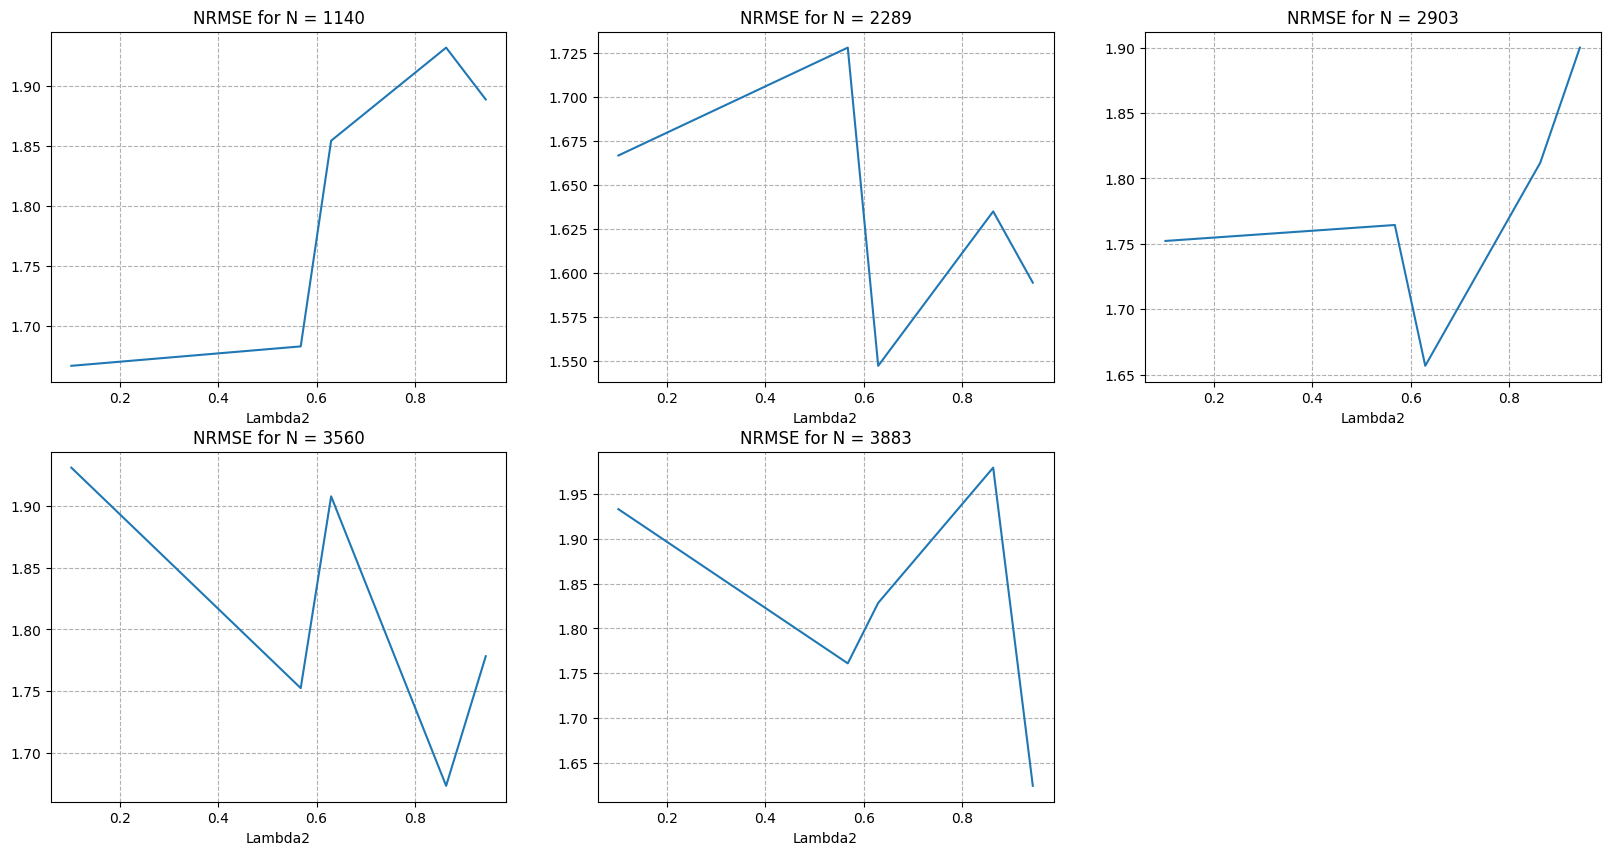

In [26]:
plt.figure(figsize = (20, 10))#output window size

for i in range(len(N_array)):#looping for 5 subplots
    plt.subplot(2, 3, i+1)#position of the ith subplot
    plt.plot(l2_coeff_array, average_NRMSE_array_task_10[i])#plot of the data
    plt.xlabel('Lambda2')#Lambda2 on the x axis
    plt.title(f"NRMSE for N = {N_array[i]}")#Plot title
    plt.grid(True, which="both", ls="--")#Setting the grid lines on the plot

plt.show()#showing the plot

# Task 11 - Impact of $\lambda_1$ on variable elimination

## 1. Independent columns in X

- Generating the data matrix - 2000 x 5

In [27]:
Data_array_task_11 = gen_data_matrix(2000, np.identity(5)) #Generating the data matrix
Target_array_task_11 = np.random.normal(0, 1, 2000) #Generating the target array 

- Generating an array of $\lambda_1$ $\epsilon$ [0, 1.5]

In [28]:
l1_coeff_array = (np.arange(15) + 1)/10 # = {1/15, 2/15, 3/15,..., 1}

In [29]:
Weight_array = [] #this will hold the weights after the iterations
for i in range(len(l1_coeff_array)): #looping over the lambda1 array
    Weight_array.append(grad_descent(Data_array_task_11, Target_array_task_11, 0.5, 0, l1_coeff_array[i], 0.001))#appending the result of gradient descent to the weight array
Weight_array = np.array(Weight_array) #converting to numpy array for ease of use

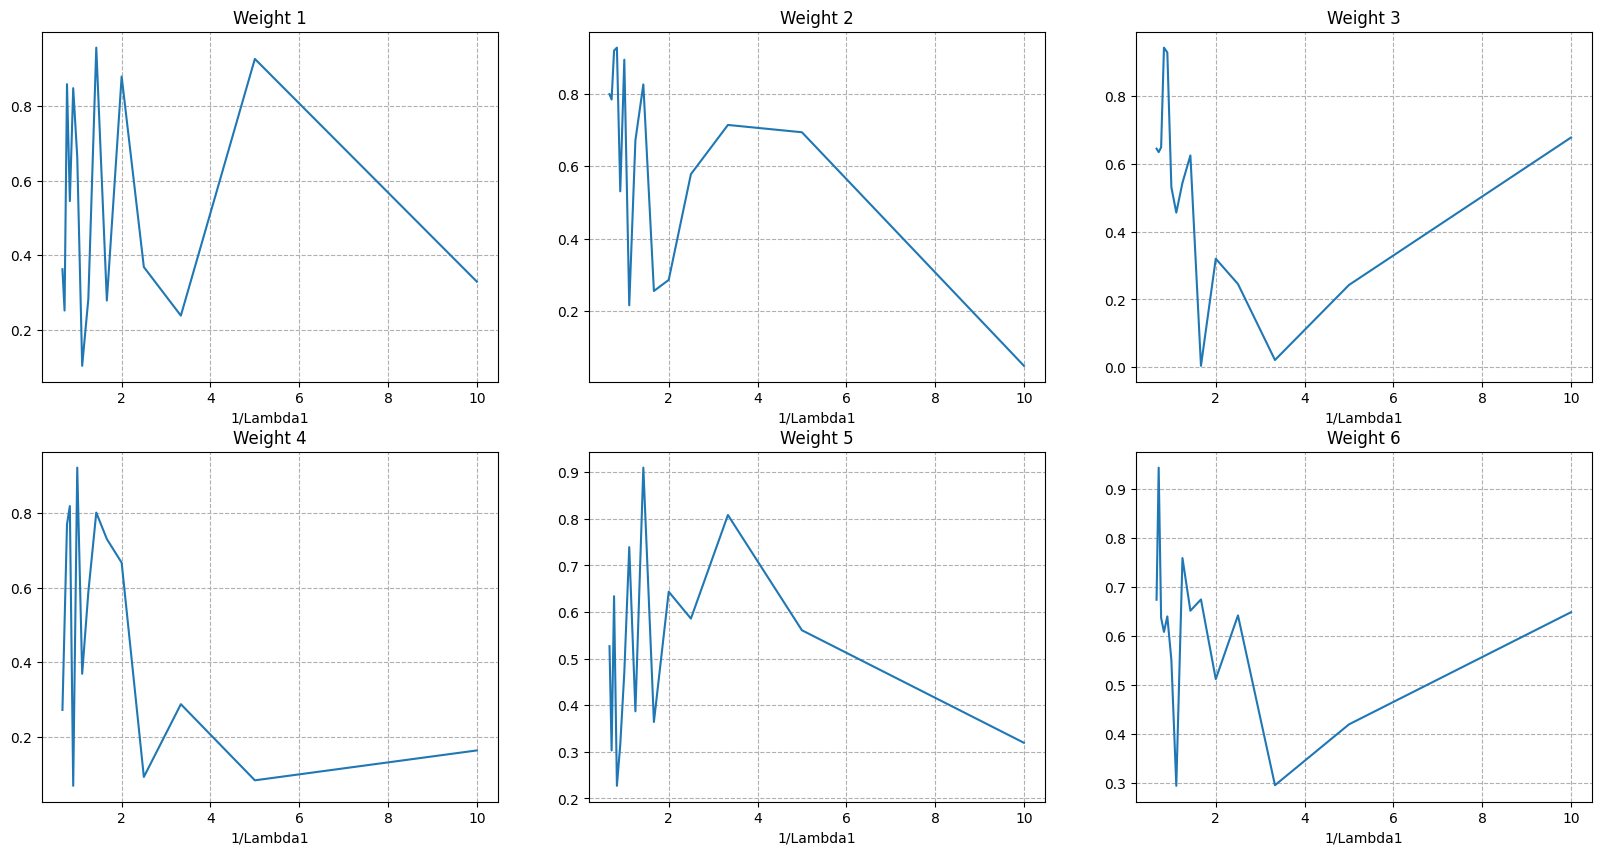

In [30]:
plt.figure(figsize = (20, 10)) #setting the figure size for the plot

for i in range(6): #looping for 6 subplots
    plt.subplot(2, 3, i+1) #subplot position
    plt.plot(1/l1_coeff_array, Weight_array[:,i]) #plot
    plt.xlabel('1/Lambda1') #x label
    plt.title(f"Weight {i + 1}") #Title
    plt.grid(True, which="both", ls="--") #Setting grid

plt.show() #showing the plot

## 2. Presence of correlations in X

- Creating a 5x5 generator matrix with linearly dependent columns

In [31]:
G_task11_2 = np.zeros((5, 5)) #intializing the generator matrix as an array of zeroes
G_task11_2[:, 0] = np.random.randint(low=1, high=10, size=5) #Random length 5 column
for i in range(1, 5): #Generating the subsquent columns 
    G_task11_2[:, i] = (i*G_task11_2[:, 0])/5 #Other columsn are scaled versions of the first column

- Generating the data matrix - 2000 x 5

In [32]:
Data_array_task_11_2 = gen_data_matrix(2000, G_task11_2) #Generating the data matrix out of the correlated column generator matrix
Target_array_task_11_2 = np.random.normal(0, 1, 2000) #Generating the target array 

- Generating an array of $\lambda_1$ $\epsilon$ [0, 1.5]

In [33]:
l1_coeff_array = (np.arange(15) + 1)/10 # = {1/10, 2/10, 3/10,..., 1.5}

- Conducting the experiment for the data with correlations

In [34]:
Weight_array_2 = [] #this will hold the weights after the iterations
for i in range(len(l1_coeff_array)): #looping over the lambda1 array
    Weight_array_2.append(grad_descent(Data_array_task_11_2, Target_array_task_11_2, 0.5, 0, l1_coeff_array[i], 0.001))#appending the result of gradient descent to the weight array
Weight_array_2 = np.array(Weight_array_2) #converting to numpy array for ease of use

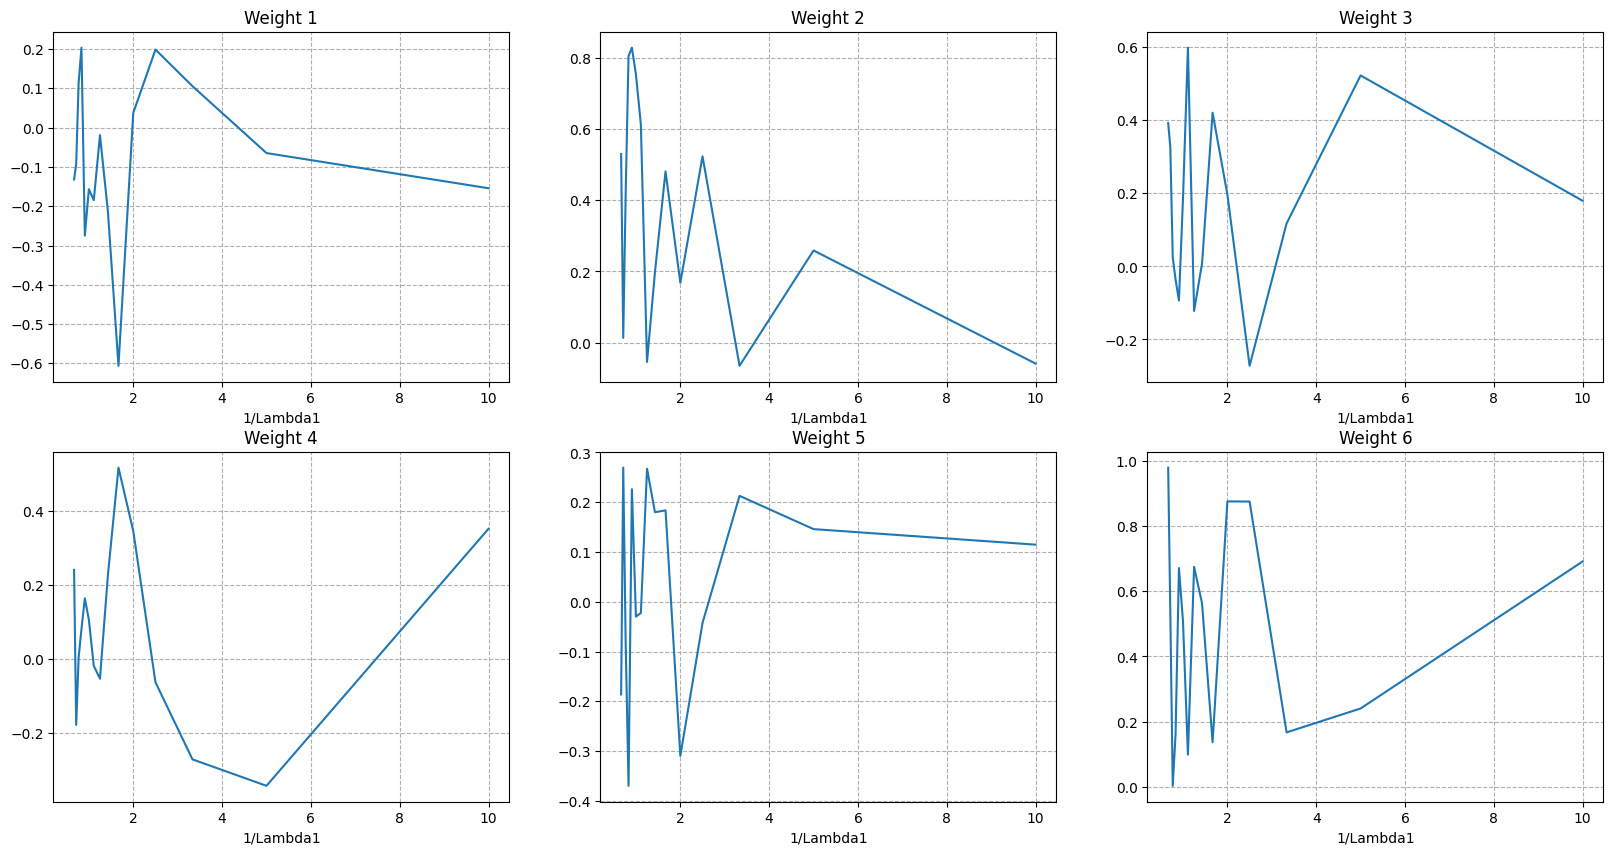

In [35]:
plt.figure(figsize = (20, 10)) #setting the figure size for the plot

for i in range(6): #looping for 6 subplots
    plt.subplot(2, 3, i+1) #subplot position
    plt.plot(1/l1_coeff_array, Weight_array_2[:,i]) #plot
    plt.xlabel('1/Lambda1') #x label
    plt.title(f"Weight {i + 1}") #Title
    plt.grid(True, which="both", ls="--") #Setting grid

plt.show() #showing the plot

# Task 12 - Grouping effect of elastic net

- The same correlated dataset as used in task 11 and the same l2 coefficients as used in task 10 will be used  

In [36]:
Weight_array_12 = [] #this will hold the weights after the iterations
for i in range(len(l2_coeff_array)): #looping over the lambda1 array
    Weight_array_12.append(grad_descent(Data_array_task_11_2, Target_array_task_11_2, 0.5, l2_coeff_array[i], 0, 0.001))#appending the result of gradient descent to the weight array
Weight_array_12 = np.array(Weight_array_12) #converting to numpy array for ease of use

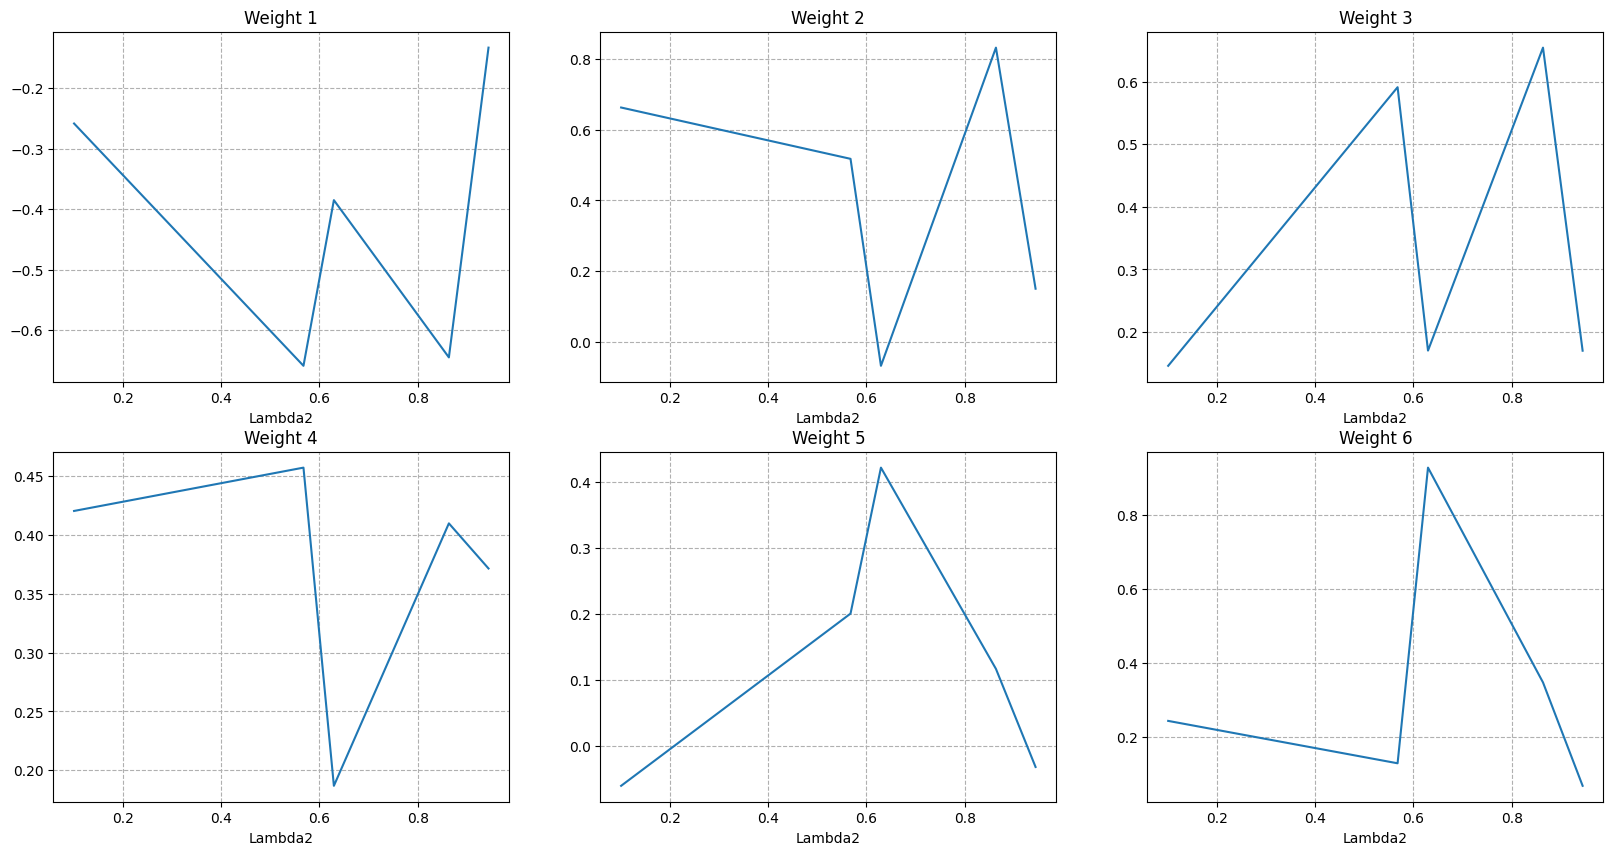

In [37]:
plt.figure(figsize = (20, 10)) #setting the figure size for the plot

for i in range(6): #looping for 6 subplots
    plt.subplot(2, 3, i+1) #subplot position
    plt.plot(l2_coeff_array, Weight_array_12[:,i]) #plot
    plt.xlabel('Lambda2') #x label
    plt.title(f"Weight {i + 1}") #Title
    plt.grid(True, which="both", ls="--") #Setting grid

plt.show() #showing the plot

# Task 13 - Linear binary classification vector  

### This function is analogous to the get_target function as used for linear regression

In [38]:
def step_func(x, threshold): #defining the step function for thresholding
    output = [] #this will hold the thresholded array
    for i in range(len(x)): #looping through the elements of x
        output.append(1 if x[i] > threshold else 0) #applying the thresholding
    return output #function return

def sigmoid(x): #sigmoid function
    return 1/(1+np.exp(-x)) #sigmoid calculation using the esponential function in numpy

In [39]:
def get_lin_bin_class(X, W, noise_var, sigmoid_threshold): #function declaration
    d = np.array(X).shape[1] #number of columns in X
    #dimension mismatch check
    if(len(W) != d + 1): 
       #[2]
       raise RuntimeError(f"Provided weight vector is of dimension {len(W)}, expected {d+1}") #raises runtime error for dimesion mismatch
    #If dimensions match
    sigmoid_h = sigmoid(np.dot(np.array(X), W[0:d]) + W[d] + np.random.normal(0, noise_var)) #Sigmoid of WtX + Bias + noise
    
    return step_func(sigmoid_h, sigmoid_threshold) #function return

# Task 14 - Gradient of Binary Cross-Entropy 

#### Binary Cross Entropy Loss = - $\sum_{i=1}^{n} [t_ilog(\sigma(X_iW + noise)) + (1 - t_i)log(1 - \sigma(X_iW + noise))]$

#### $\nabla_w$ BCE = $\sum_{i=1}^{n} (\sigma(X_iW + noise) - t_i)(X_i)$

#### Here X includes a column of ones and W includes the bias term

In [40]:
def grad_bce(Y, T, X): #Y : predictions for all the datapoints T : Targets for all the datapoints 
    GRAD_BCE =  np.zeros((np.array(X).shape[1]) + 1) #this array of length d + 1 will be the gradient vector

    for i in range(len(T)):#looping through all the datapoints for summation 
        X_i = np.array(X[i]) #ith row of X - that is the ith datapoint
        X_i = np.append(X_i, 1) #appending 1 to the ith row to accomodate for bias in W 
        #Assuming W is of length d+1, including the bias
        GRAD_BCE = GRAD_BCE + (Y[i] - T[i])*(X_i) #calculation

    return GRAD_BCE #function return

#### Gradient descent function for BCE loss

In [41]:
def grad_descent_BCE(X, T, noise_var, l2_coeff, l1_coeff, learning_rate, sigmoid_threshold): #Returns the best weights and (optionally) the NRMSE values
    W_OLD = np.random.rand(np.array(X).shape[1] + 1) #random array of dimension d + 1
    L2_PENALTY = np.append(l2_coeff*grad_l2(W_OLD), 0) #appending 0 to the L2 GRADIENT array to make it of dimension d+1 for adding to the MSE gradient
    L1_PENALTY = np.append(l1_coeff*grad_l1(W_OLD), 0) #appending 0 to the L1 GRADIENT array to make it of dimension d+1 for adding to the MSE gradient
    GRADIENT_W_OLD = grad_bce(get_lin_bin_class(X, W_OLD, noise_var, sigmoid_threshold), T, X) + L2_PENALTY + L1_PENALTY #total gradient
    W_NEW = W_OLD - learning_rate*(GRADIENT_W_OLD) #Weight update equation
    i = 0 #keeps track of the number of iterations
    while((nrmse(T, get_lin_bin_class(X, W_NEW, noise_var, sigmoid_threshold)) > 3) and i < 500):#running the loop with the termination condition on the NRMSE 
          W_OLD = W_NEW #updating W_OLD for further iteration
          L2_PENALTY = np.append(l2_coeff*grad_l2(W_OLD), 0) #appending 0 to the L2 GRADIENT array to make it of dimension d+1 for adding to the MSE gradient
          L1_PENALTY = np.append(l1_coeff*grad_l1(W_OLD), 0) #appending 0 to the L1 GRADIENT array to make it of dimension d+1 for adding to the MSE gradient
          GRADIENT_W_OLD = grad_bce(get_lin_bin_class(X, W_OLD, noise_var, sigmoid_threshold), T, X) + L2_PENALTY + L1_PENALTY #total gradient
          W_NEW = W_OLD - learning_rate*(GRADIENT_W_OLD) #Weight update equation
          i += 1 #increment on completion of an iteration
    
    return W_NEW #function return 

# Task 15 -  Impact of N and $\lambda_2$ on the NRMSE for Linear classification

- The experiment is run on 5 Iterations, G and $\sigma$ being constant throughout the iterations. Taking G to be a 5x5 identity matrix, i.e., d = 5
- Keeping $\lambda_1$ = 0

### Generating N and $\lambda_2$ array 

In [42]:
l2_coeff_array_15 = np.sort(np.random.rand(5)) #generates a sorted random array of length 5 with values uniformly sampled from [0,1)
#[4]
N_array_15 = np.sort(np.random.randint(low=500, high=5000, size=5)) #generates a random length 5 array with integer values uniformly sampled from {500, 501,..., 5000} 
#Sorting helps in organized plotting 

In [43]:
noise_var_task_15 = 0.5 #choosing noise variance
d = 5 #dimension of each datapoint

#[5]
Data_array_task_15 = np.empty(len(N_array), dtype=object) #This array of objects will store the 5 different data matrices
Target_array_task_15 = np.empty(len(N_array), dtype=object) #This array of objects will store the 5 different target arrays

Train_data_array_task_15 = np.empty(len(N_array), dtype=object) #This array of objects will store the 5 different train data matrices
Test_data_array_task_15 = np.empty(len(N_array), dtype=object) #This array of objects will store the 5 different test data matrices

Train_target_array_task_15 = np.empty(len(N_array), dtype=object) #This array of objects will store the 5 different train target arrays
Test_target_array_task_15 = np.empty(len(N_array), dtype=object)  #This array of objects will store the 5 different test target arrays

for j in range(len(N_array)): #looping through the array of n values
    n = N_array[j] #reading the jth entry of the array of N values
    Data_array_task_15[j] = gen_data_matrix(n, np.identity(d)) #generating the data matrix for each N with the identity generator
    Target_array_task_15[j] = np.random.randint(low=0, high=2, size=n) #randomly assigning gaussian sampled values to the target array
    
    Train_data_array_task_15[j] = Data_array_task_15[j][0:int(4*n/5)] #slicing the Data tensor for the first 4n/5 entries for training
    Test_data_array_task_15[j] = Data_array_task_15[j][int(4*n/5):int(n)] #slicing the Data tensor for the last n/5 entries for validation
    
    Train_target_array_task_15[j] = Target_array_task_15[j][0:int(4*n/5)] #slicing the Target array for the first 4n/5 entries for training
    Test_target_array_task_15[j]  = Target_array_task_15[j][int(4*n/5):int(n)]  #slicing the Target array for the last n/5 entries for validation

- Conducting the experiment looping 5 times

In [44]:
average_NRMSE_array_task_15 = np.zeros((len(N_array), len(l2_coeff_array))) #holds the NRMSE, averaged over the 5 iterations in a 5x5 array | Axis0 = N | Axis1 = Lambda2 |

for i in range(5):#5 iterations 
    NRMSE_array = np.empty((len(l2_coeff_array), len(N_array)), dtype=object) #holds the NRMSE values for the 25 iterations 
    for i in range(len(l2_coeff_array)): #looping for all the different l2 coefficient values 
        for j in range(len(N_array)): #looping for all the different N values
            Weights_i_j = grad_descent_BCE(Train_data_array_task_15[j], Train_target_array_task_15[j], noise_var_task_15, l2_coeff_array_15[i], 0, 0.001, 0.5) #updating the weight array, performing gradient descent 
            average_NRMSE_array_task_15[j][i] += nrmse(Test_target_array_task_15[j], get_lin_bin_class(Test_data_array_task_15[j], Weights_i_j, noise_var_task_15, 0.5)) #updating the NRMSE array

average_NRMSE_array_task_15 = average_NRMSE_array_task_15/5 #dividing by 5 for averaging         

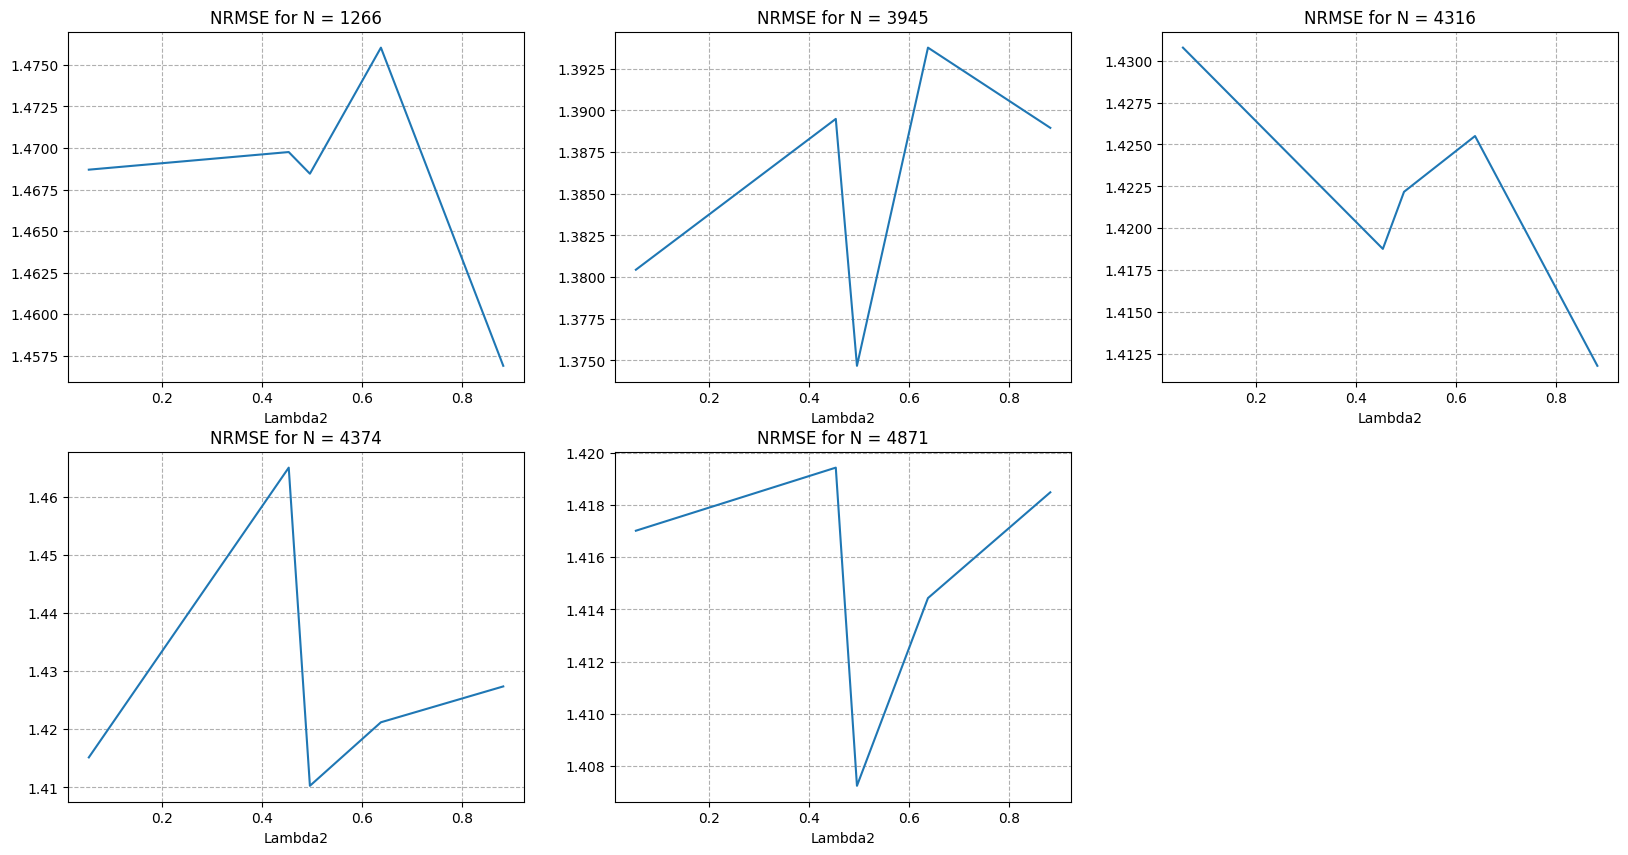

In [45]:
plt.figure(figsize = (20, 10))#window size

for i in range(len(N_array_15)):#looping for 5 subplots
    plt.subplot(2, 3, i+1)#position of the ith subplot
    plt.plot(l2_coeff_array_15, average_NRMSE_array_task_15[i])#plot of the data
    plt.xlabel('Lambda2')#Lambda2 on the x axis
    plt.title(f"NRMSE for N = {N_array_15[i]}")#Plot title
    plt.grid(True, which="both", ls="--")#Setting the grid lines on the plot

plt.show()#showing the plot

# References:  
[1]: ChatGPT prompt: How to set the underlying distribution in the random function in np.random  
[2]: ChatGPT prompt: How to set a raise error condition if my function is called on an illegal input  
[3]: ChatGPT prompt: How to set log scale in a scatter plot in pyplot  
[4]: ChatGPT prompt: Generating a random integer numpy array from a certain range  
[5]: ChatGPT prompt: Create a 5x5 array with each element of the array being a uniquely shaped matrix   